In [8]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [9]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [10]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [11]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))


In [12]:
# 数据预处理
# 计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))  # 记住apply这个函数

# 在标准化数据之后，所有均值为0，因此可以将缺失值设为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# 接下来处理离散值，用独热编码替换它们
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
# 最后，通过values属性，我们可以 从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练。

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

折1，训练log rmse0.131025, 验证log rmse0.145266
折2，训练log rmse0.128642, 验证log rmse0.146159
折3，训练log rmse0.127029, 验证log rmse0.143029
折4，训练log rmse0.132100, 验证log rmse0.136267
折5，训练log rmse0.125529, 验证log rmse0.167466
5-折验证: 平均训练log rmse: 0.128865, 平均验证log rmse: 0.147637


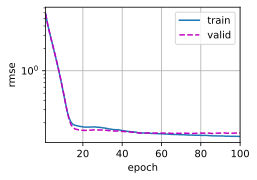

In [13]:
# 定义一个简单的模型
in_features = train_features.shape[1]
loss = nn.MSELoss()
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super().__init__()
        self.linear1 = nn.Linear(n_feature, 512)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(512, 1)
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        return x
net = LinearNet(in_features)

def log_rmse(net, features, labels):
    '''对数均方根误差'''
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
        return rmse.item()

# 训练模型
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, weight_decay, batch_size):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)

    for _ in range (num_epochs): # 训练num_epochs个周期
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k  # 每个折叠的样本数
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, lr, weight_decay, batch_size):
    train_loss_sum, valid_loss_sum = 0, 0 
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = LinearNet(in_features)
        train_ls, valid_ls = train(net, *data, num_epochs, lr, weight_decay, batch_size)
        train_loss_sum += train_ls[-1]
        valid_loss_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, 'f'验证log rmse{float(valid_ls[-1]):f}')
    return train_loss_sum / k, valid_loss_sum / k

k = 5
num_epochs = 100
lr = 0.01
weight_decay = 1e-3
batch_size = 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')